In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import time
import glob
import tqdm
import torch
import warnings
import numpy as np
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
import matplotlib.pyplot as plt
from toolz.curried import pipe, curry, compose, memoize

In [3]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [4]:
def get_free_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)

In [5]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
    
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

# def init_unif(nsamples, dim_x, dim_y, seed=354875, scale=0.1):
#     np.random.seed(seed)
#     return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))*scale


# def init_norm(nsamples, dim_x, dim_y, seed=354875):
#     np.random.seed(seed)
#     means  = np.random.uniform(-0.1, 0.1, size=nsamples)
#     scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
#     x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
#     x_data = np.concatenate(x_data, axis=0)
    
#     np.clip(x_data, -0.95, 0.95, out=x_data)
    
#     return x_data

def init_unif(nsamples, dim_x, dim_y,scale=0.1, seed=354875):
    np.random.seed(seed)
    return (2 * np.random.random((nsamples, dim_x, dim_y)) - 1) * scale


# def init_norm(nsamples, dim_x, dim_y, scale_mean=0.1, scale_std=0.1, seed=354875):
#     np.random.seed(seed)
#     means  = (2 * np.random.random(nsamples) - 1) * scale_mean
#     x_data = [np.random.normal(loc=m, scale=scale_std, size = (1, dim_x, dim_y)) for m in means]
#     x_data = np.concatenate(x_data, axis=0)
#     return x_data

def init_norm(nsamples, dim_x, dim_y, mean=0.1, std=0.1, seed=354875):
    np.random.seed(seed)
    x_data = np.random.normal(loc=mean, scale=std, size = (nsamples, dim_x, dim_y))
    return x_data

def corr(x_data, y_data):
    return pipe(x_data, 
                lambda x: np.fft.fftn(x, axes=(0,1)), 
                lambda x: x * np.conj(np.fft.fftn(y_data, axes=(0,1))), 
                lambda x: np.fft.ifftn(x),
                lambda x: np.fft.fftshift(x), 
                lambda x: x.real) / x_data.size

In [8]:
# @curry
# def init_norm(nsamples, dim_x, dim_y, seed=354875, m_l=-0.15, m_r=0.15):
#     np.random.seed(seed)
#     means  = np.random.uniform(m_l, m_r, size=nsamples)
#     np.random.seed(seed)
#     scales  = np.random.uniform(0.05, 0.3, size=nsamples)
    
#     x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
#     x_data = np.concatenate(x_data, axis=0)
    
#     np.clip(x_data, -0.98, 0.98, out=x_data)
    
#     return x_data


# @curry
# def data_generator(nsamples=2, 
#                    dim_x=64, 
#                    init_steps=1, 
#                    delta_sim_steps = 100,
#                    dx = 0.25, 
#                    dt = 0.01,
#                    gamma=1.0, 
#                    m_l=-0.15, 
#                    m_r=0.15,
#                    seed = 354875,
#                    device = torch.device("cuda:0")):
    
#     init_data = init_norm(nsamples, dim_x, dim_x, seed=seed, m_l=m_l, m_r=m_r)   

#     x_data = ch.ch_run_torch(init_data, 
#                              dt=dt, gamma=gamma, 
#                              dx=dx, sim_step=init_steps, 
#                              device=device)    

#     y_data = ch.ch_run_torch(x_data, 
#                              dt=dt, gamma=gamma, 
#                              dx=dx, sim_step=delta_sim_steps, 
#                              device=device)    
#     return x_data, y_data

In [7]:
# device = torch.device("cpu")
device = torch.device('cuda:{}'.format(get_free_gpu()) if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


In [8]:
nsamples = 32# no. of samples
dim_x = 128
dim_y = dim_x
sim_steps = 100 # simulation steps
save_steps = 100 # time step for which data is saved
dx = 0.25 # delta space_dim
dt = 0.01 # delta time
gamma = 1.0 # interface energy
min_l = -0.1
min_r = 0.1

## Evolution and Free energy calculations for normal intial state microstructures

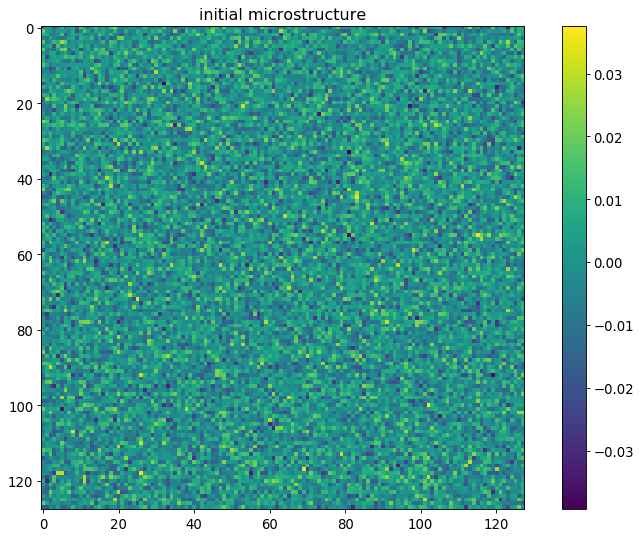

/storage/home/hhive1/ashanker9/data/anaconda3/envs/chnet/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


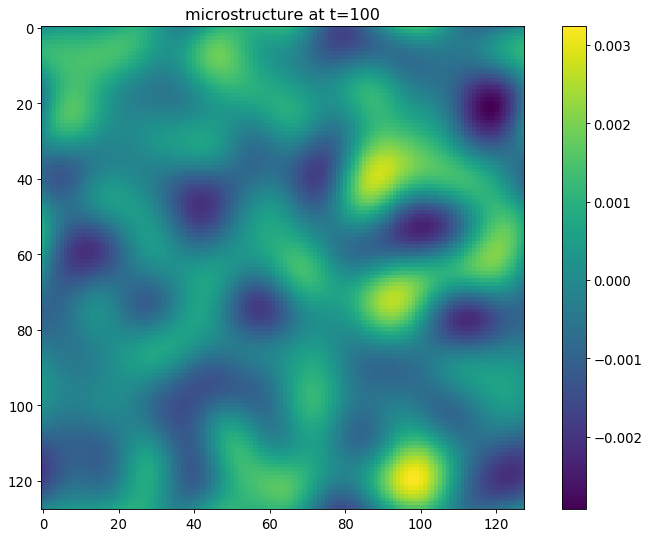

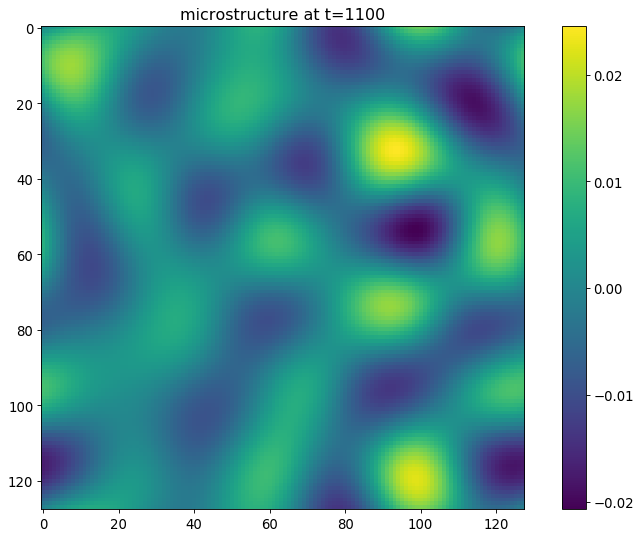

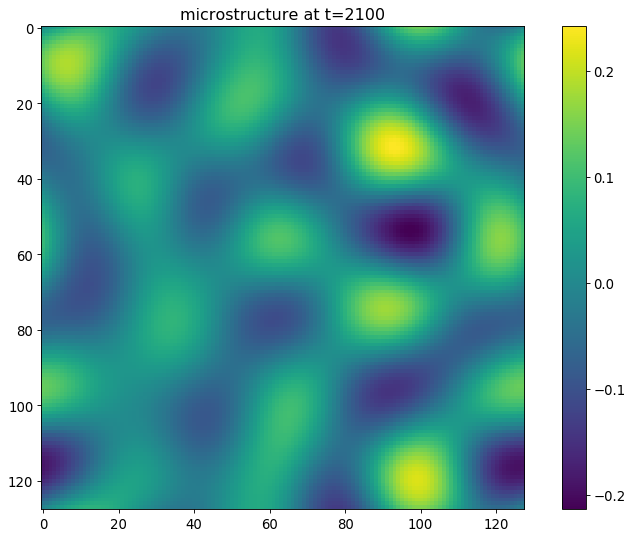

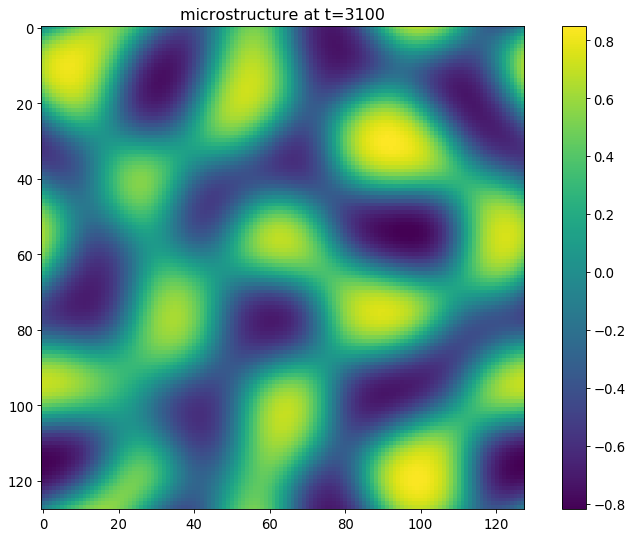

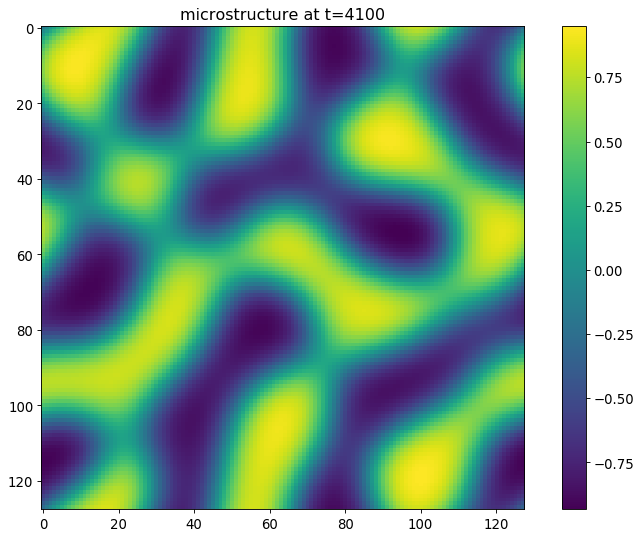

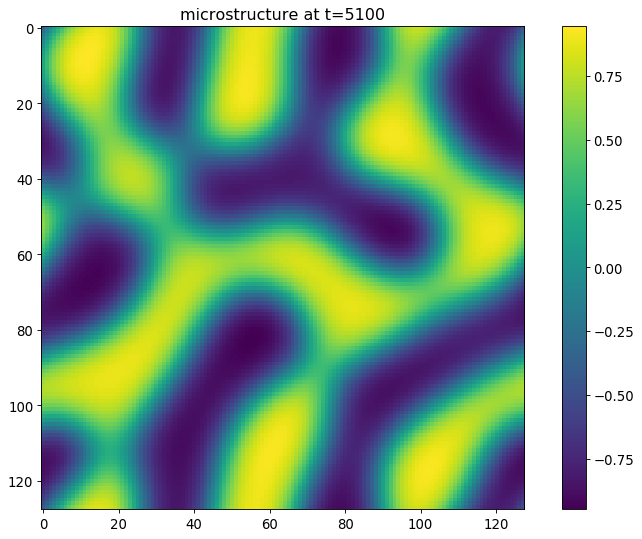

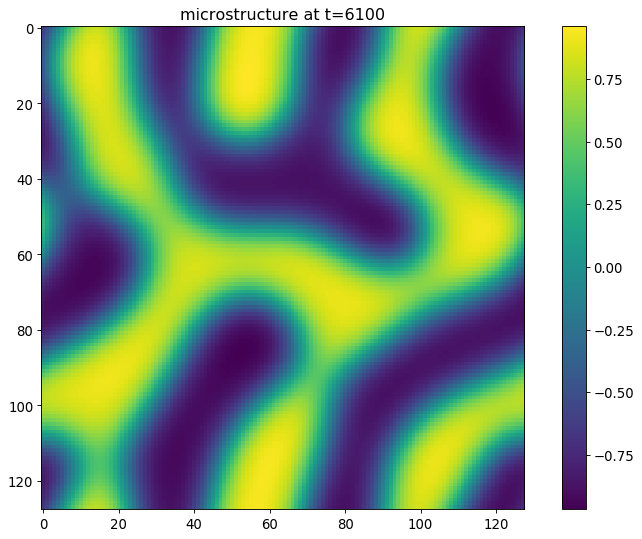

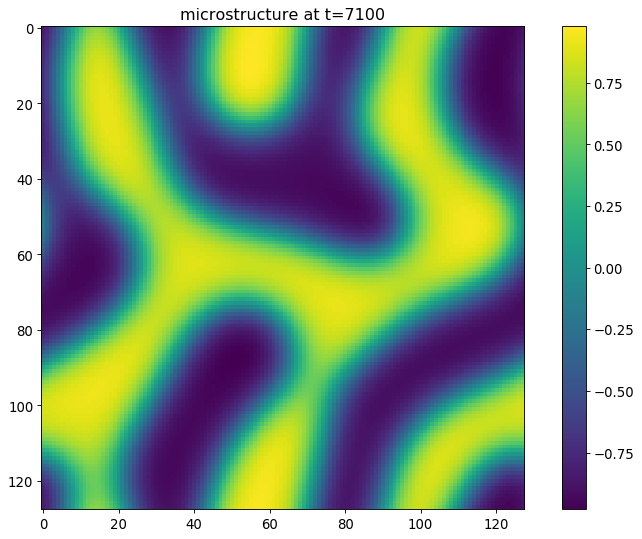

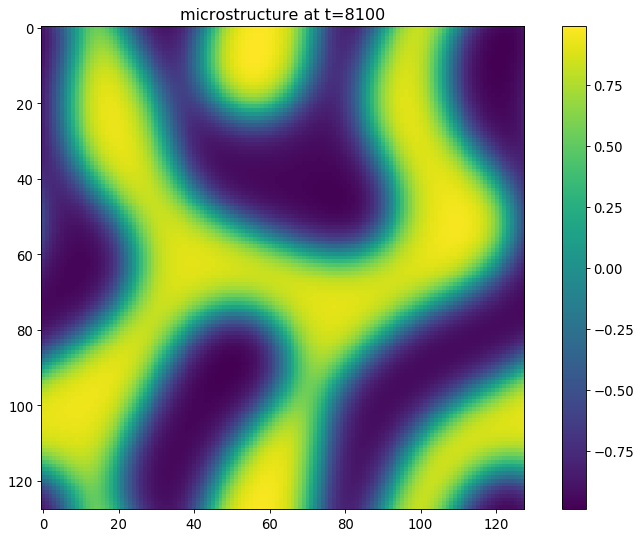

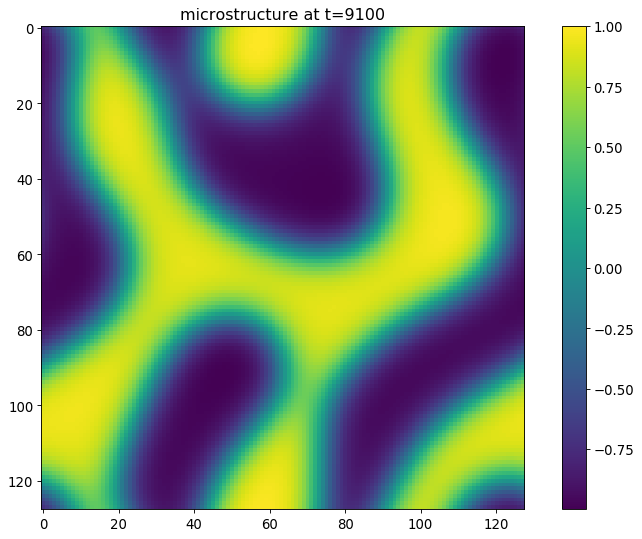

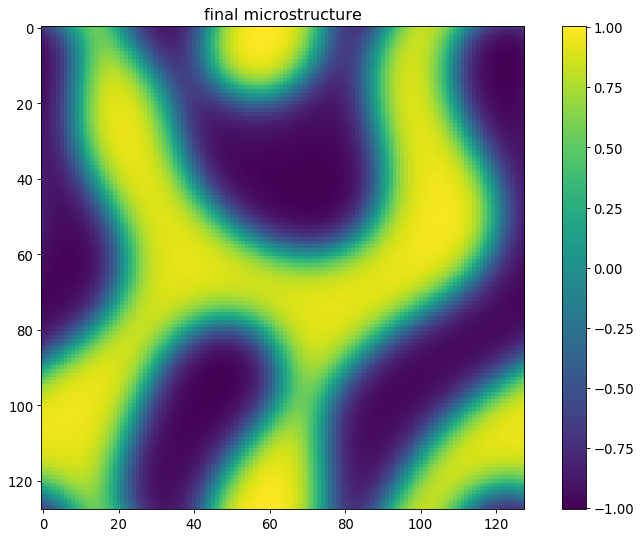

In [11]:
fe_norm1 = np.zeros((save_steps, nsamples))
x_data = init_norm(nsamples, dim_x, dim_y, mean=0.0, std=0.01, seed=873452)
for i, x in enumerate(x_data[:]):
    x_data[i,:] = x - x.mean()
x_copy = x_data.copy()
draw_im(x_data[0], "initial microstructure")

for i in tqdm.tqdm_notebook(range(save_steps)):
    x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    fe_norm1[i,:] = tools.freeEnergy(x_data, delta_x=dx, gamma=gamma)
    if (i % 10) == 0:
        draw_im(x_data[0], "microstructure at t={}".format((i+1)*100))
draw_im(x_data[0], "final microstructure")

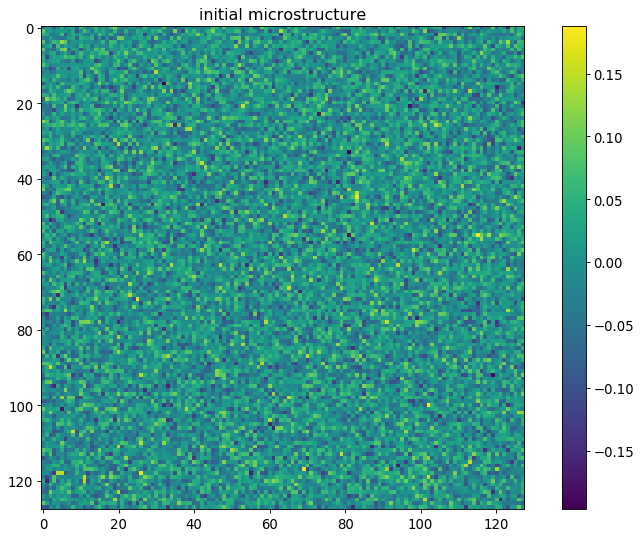

/storage/home/hhive1/ashanker9/data/anaconda3/envs/chnet/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


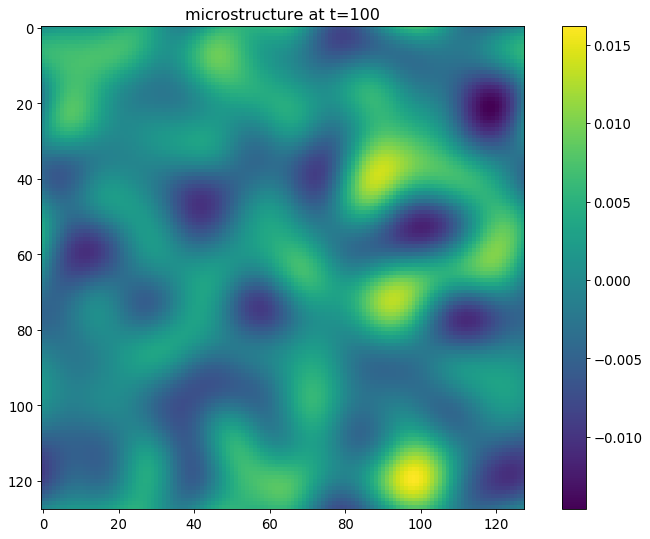

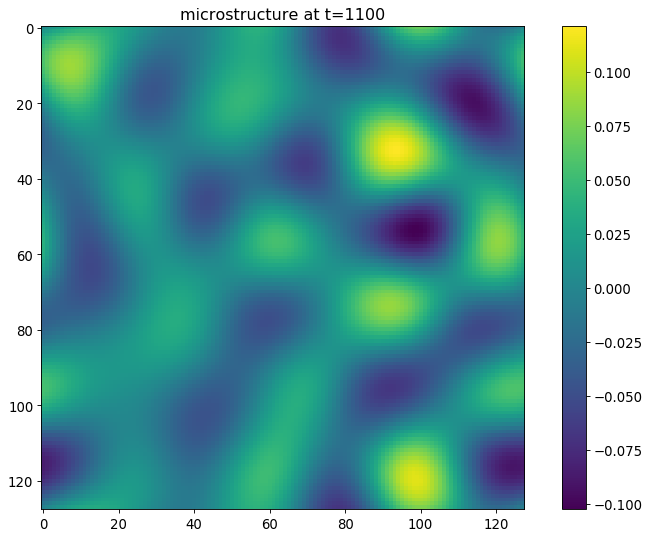

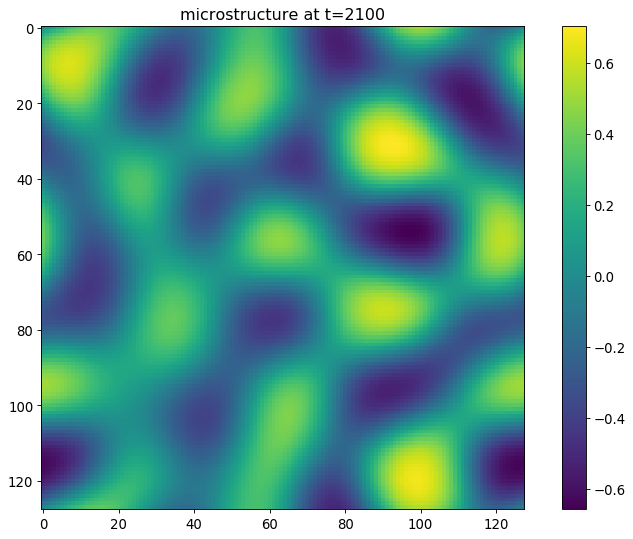

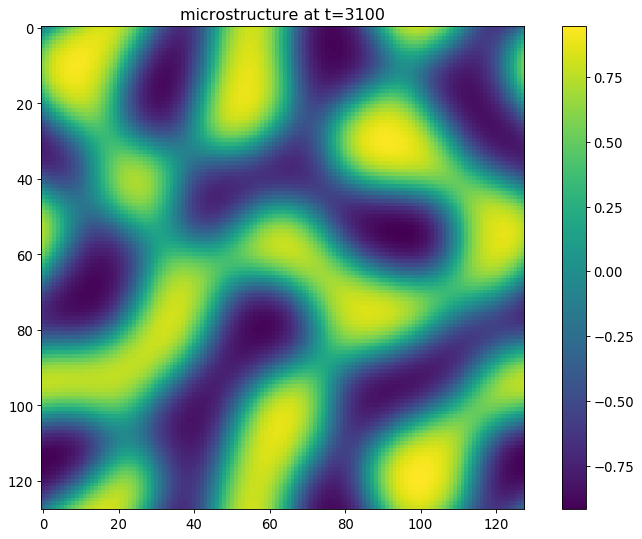

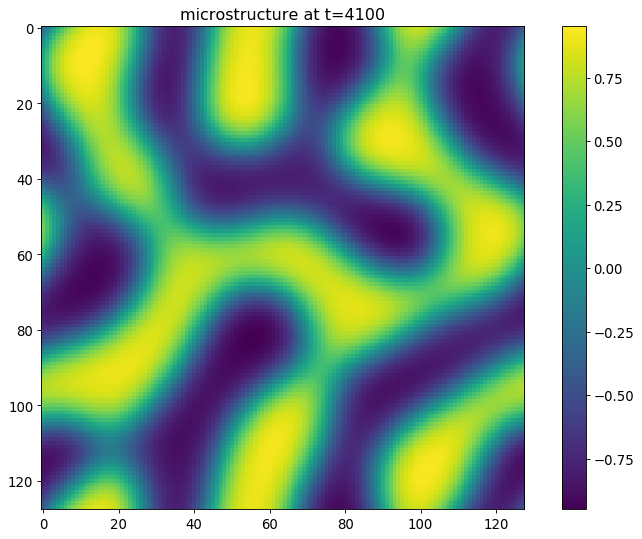

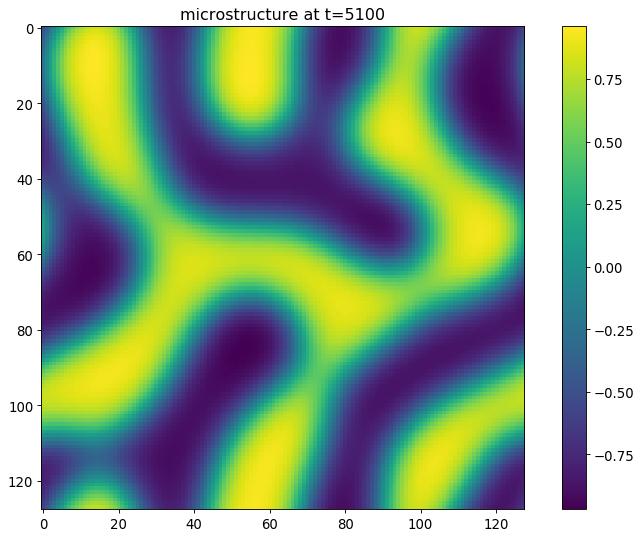

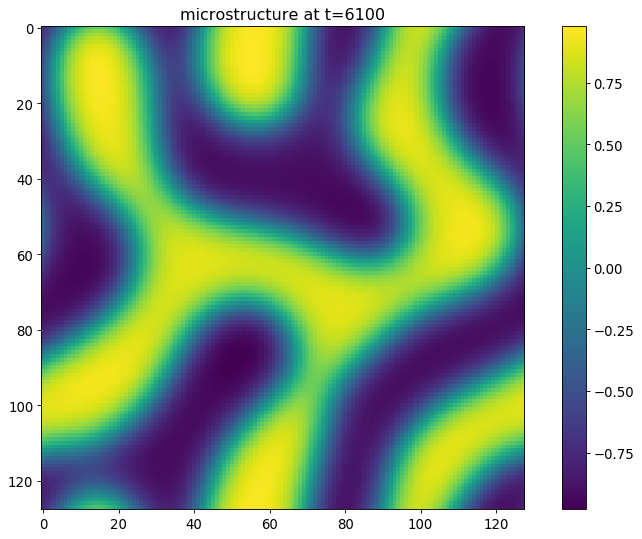

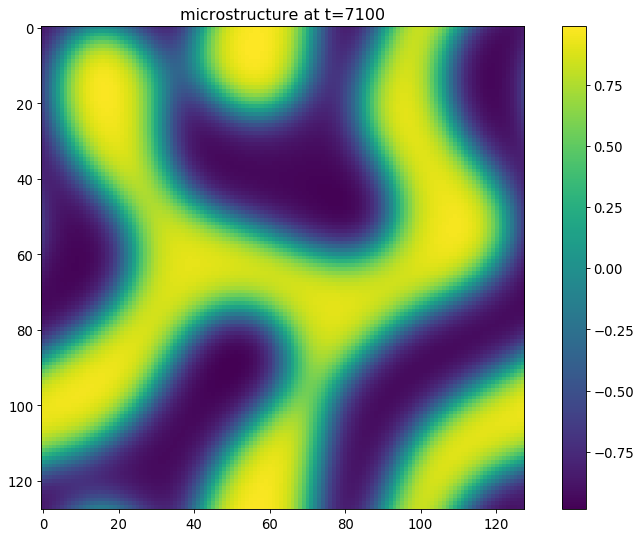

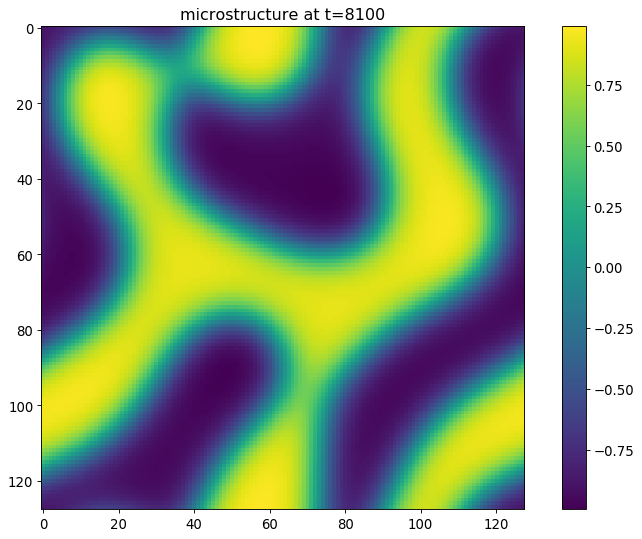

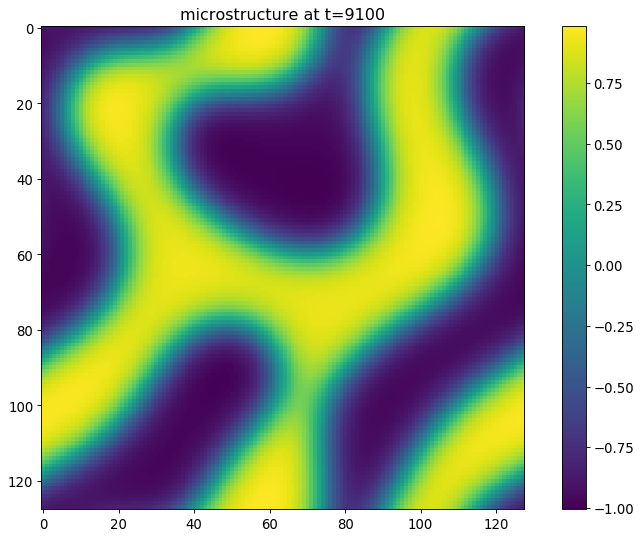

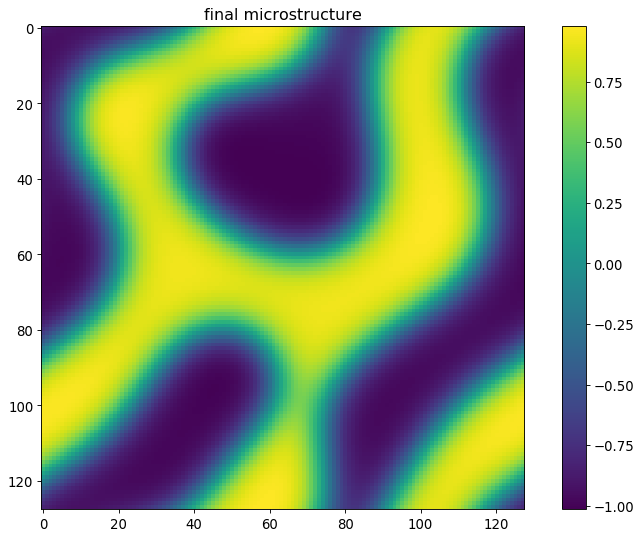

In [12]:
fe_norm2 = np.zeros((save_steps, nsamples))
x_data = x_copy.copy()*5
draw_im(x_data[0], "initial microstructure")

for i in tqdm.tqdm_notebook(range(save_steps)):
    x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    fe_norm2[i,:] = tools.freeEnergy(x_data, delta_x=dx, gamma=gamma)
    if (i % 10) == 0:
        draw_im(x_data[0], "microstructure at t={}".format((i+1)*100))
draw_im(x_data[0], "final microstructure")

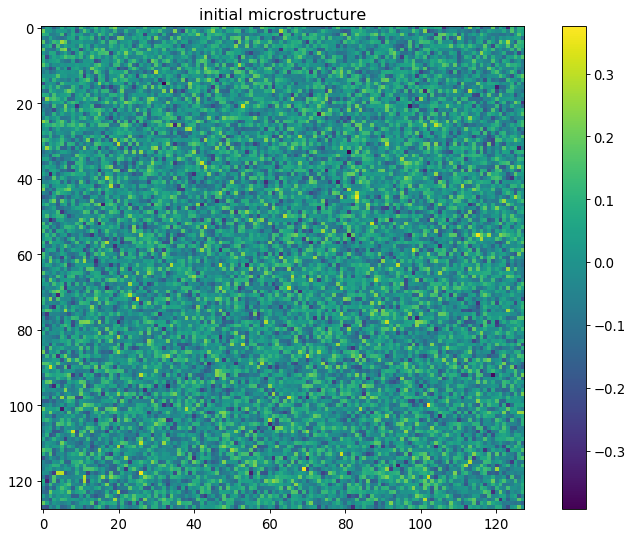

/storage/home/hhive1/ashanker9/data/anaconda3/envs/chnet/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


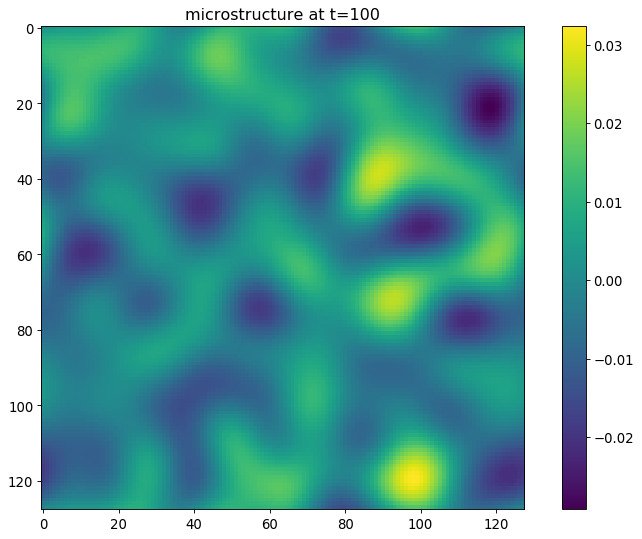

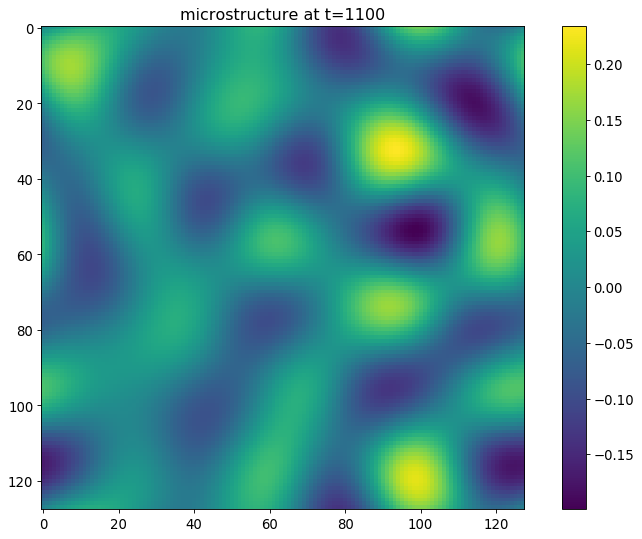

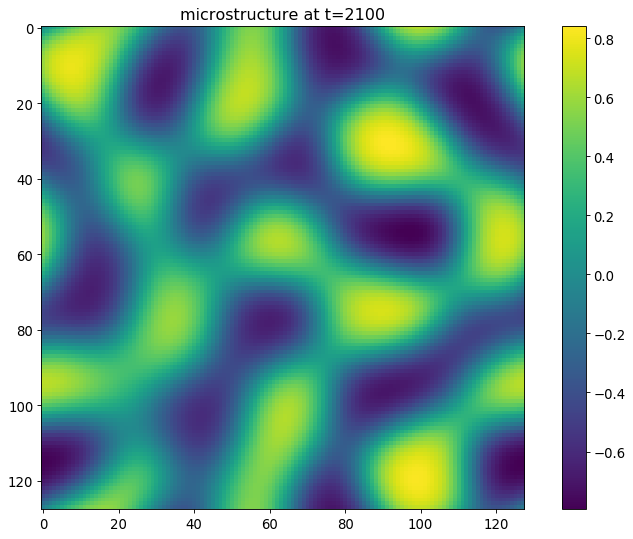

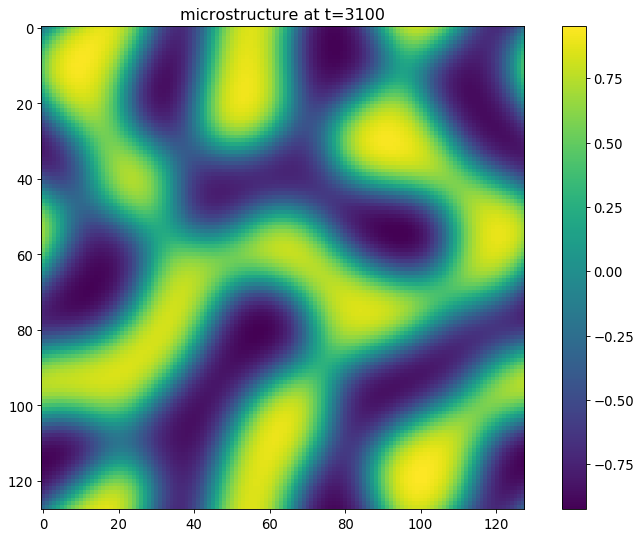

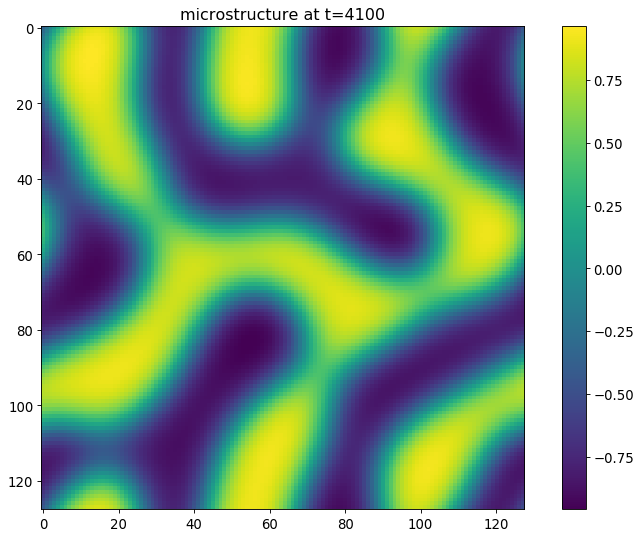

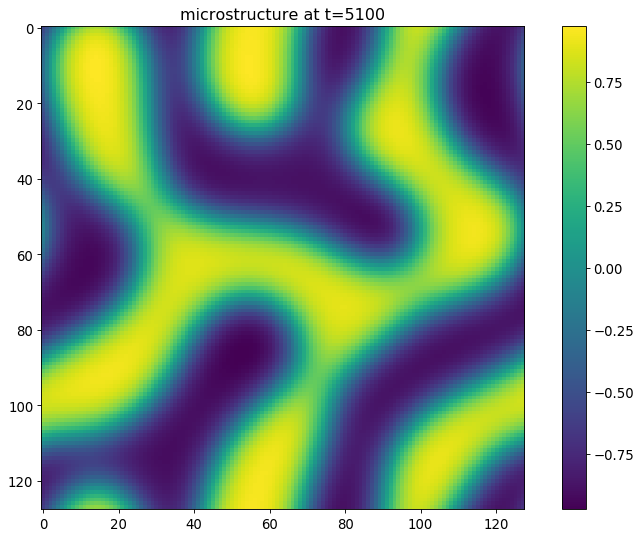

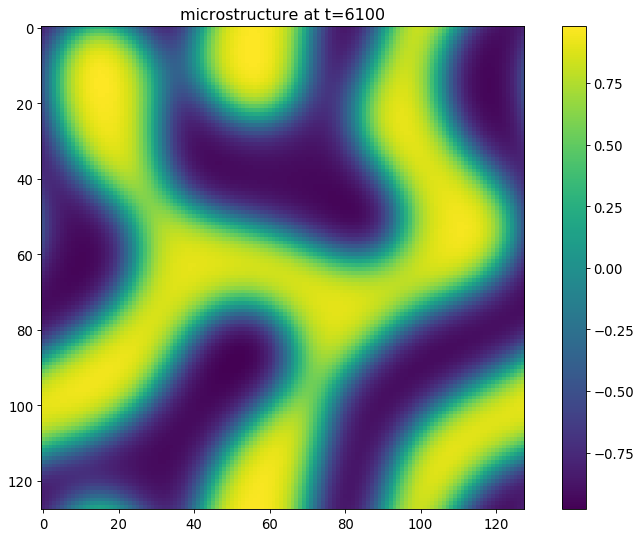

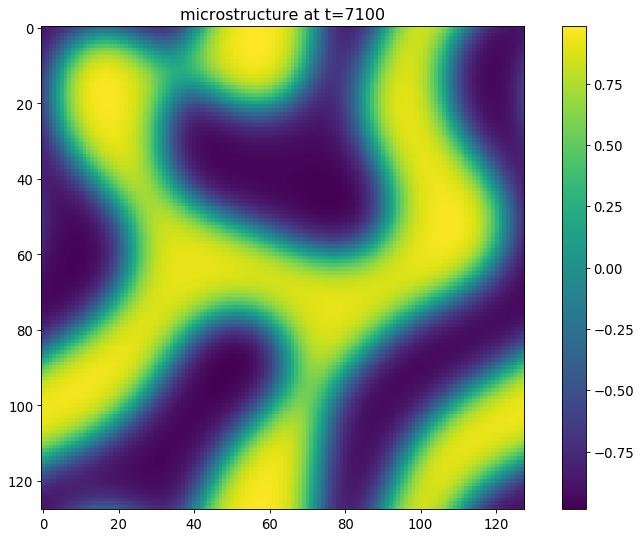

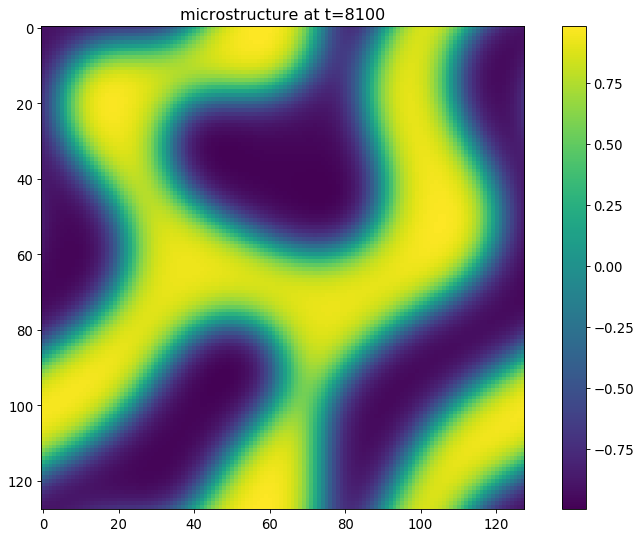

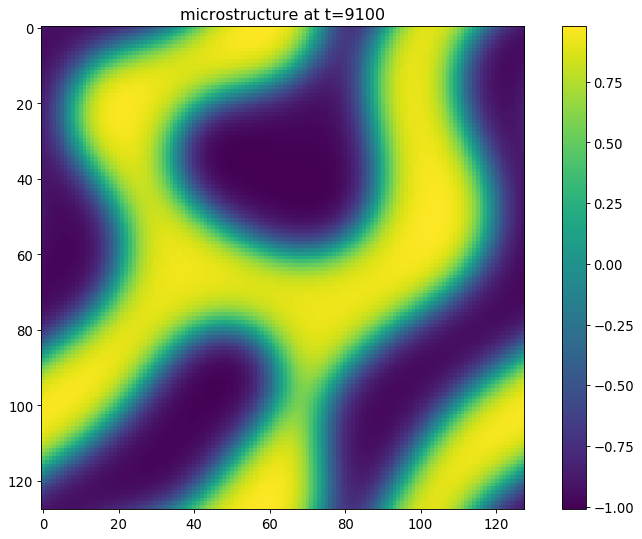

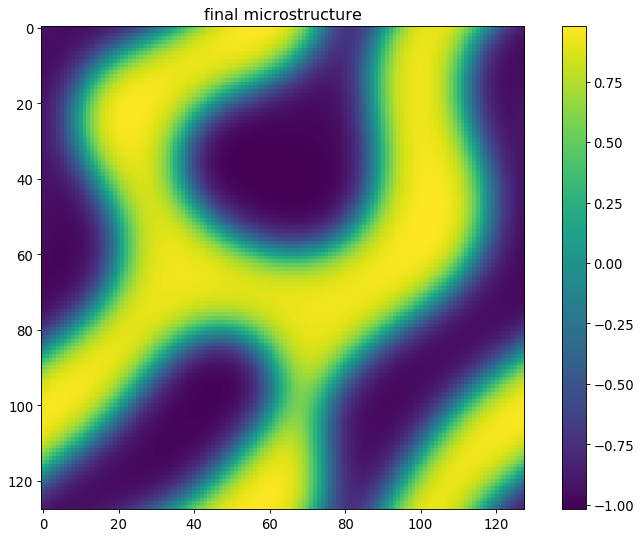

In [13]:
fe_norm3 = np.zeros((save_steps, nsamples))
x_data = x_copy.copy()*10
draw_im(x_data[0], "initial microstructure")

for i in tqdm.tqdm_notebook(range(save_steps)):
    x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    fe_norm3[i,:] = tools.freeEnergy(x_data, delta_x=dx, gamma=gamma)
    if (i % 10) == 0:
        draw_im(x_data[0], "microstructure at t={}".format((i+1)*100))
draw_im(x_data[0], "final microstructure")

## Free Energy change with microstructure evolution

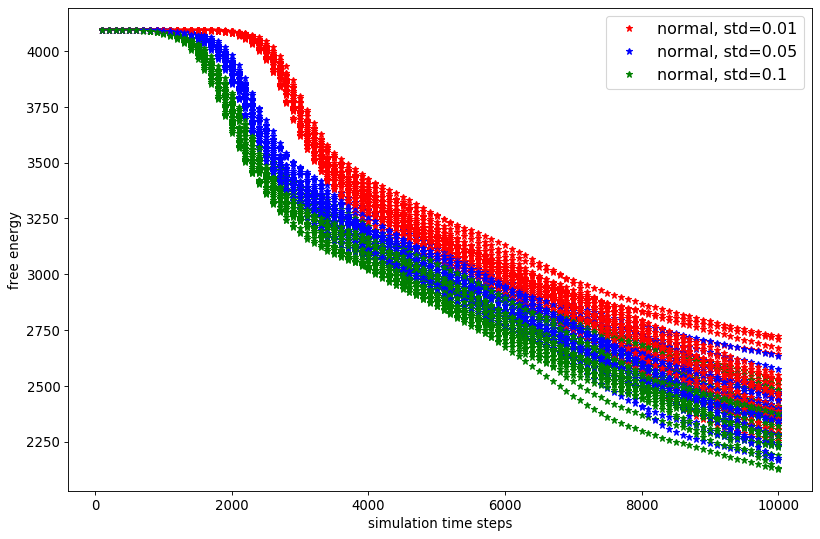

In [14]:
for i in range(nsamples):
    plt.plot(np.arange(1, save_steps+1) * sim_steps, fe_norm1[:,i], "*r")
    plt.plot(np.arange(1, save_steps+1) * sim_steps, fe_norm2[:,i], "*b")
    plt.plot(np.arange(1, save_steps+1) * sim_steps, fe_norm3[:,i], "*g")

plt.ylabel("free energy")
plt.xlabel("simulation time steps")
plt.legend(["normal, std=0.01", "normal, std=0.05", "normal, std=0.1"])
plt.show()

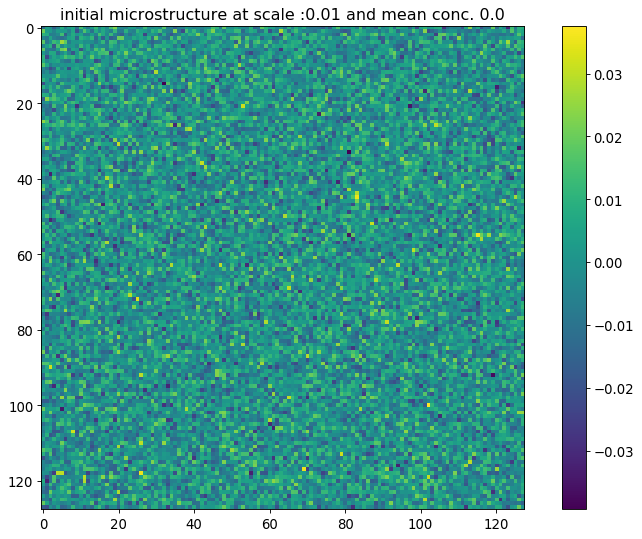

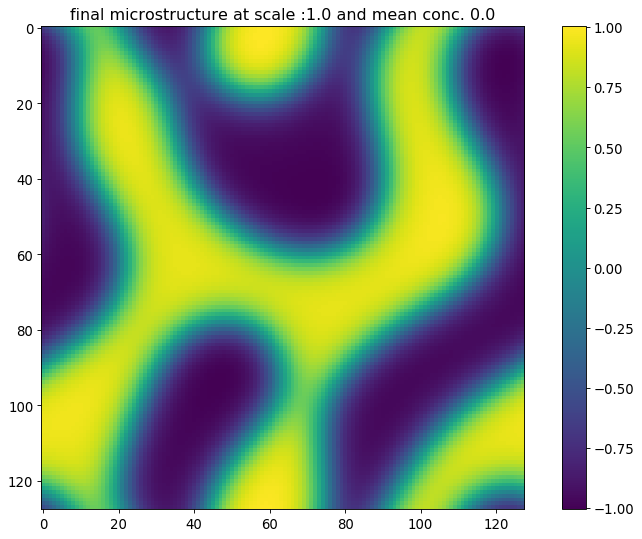

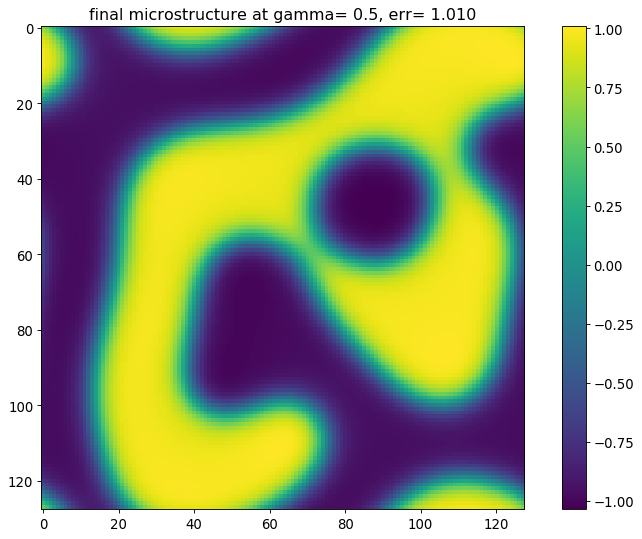

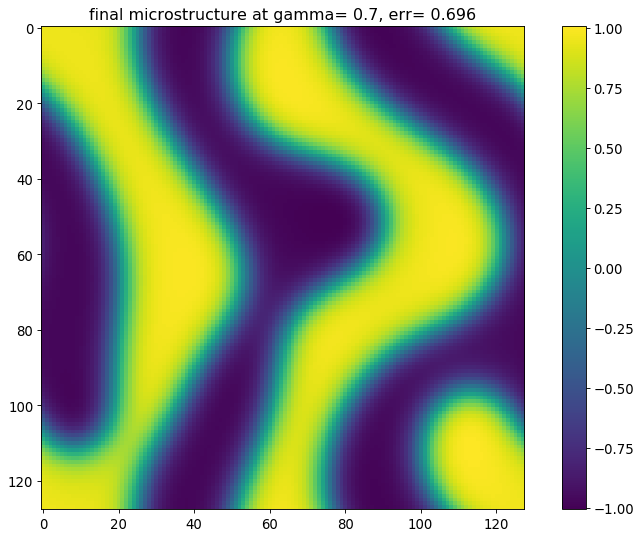

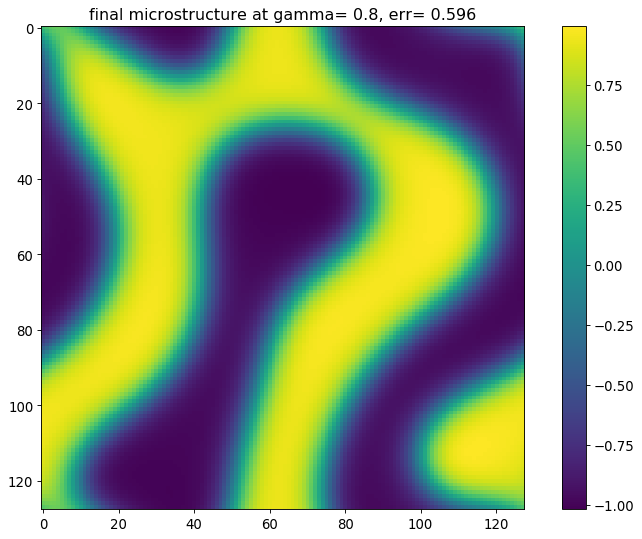

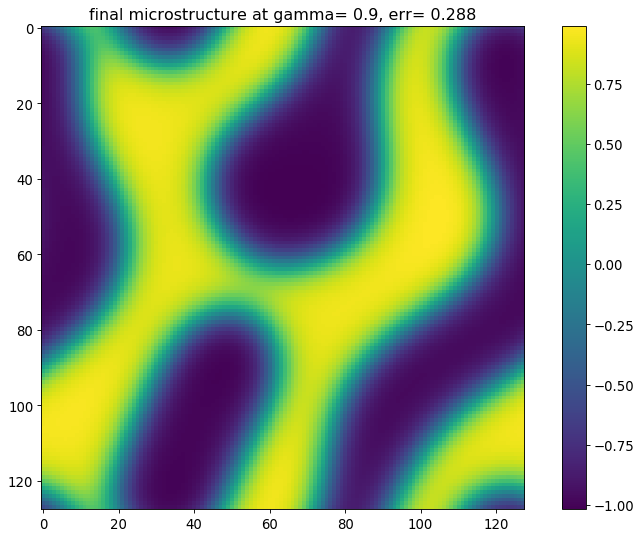

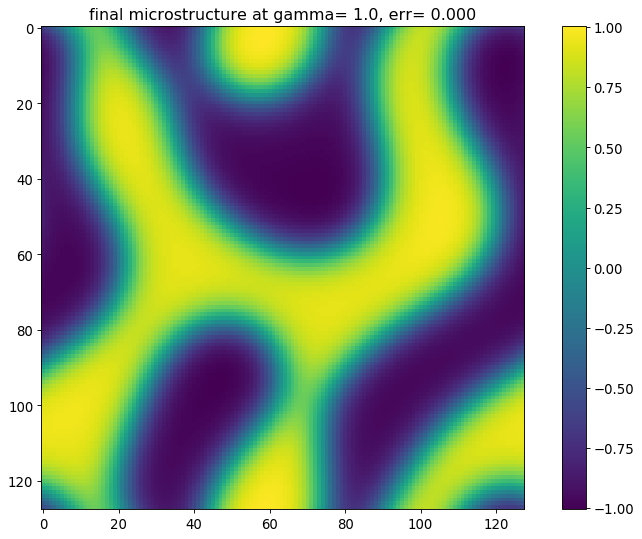

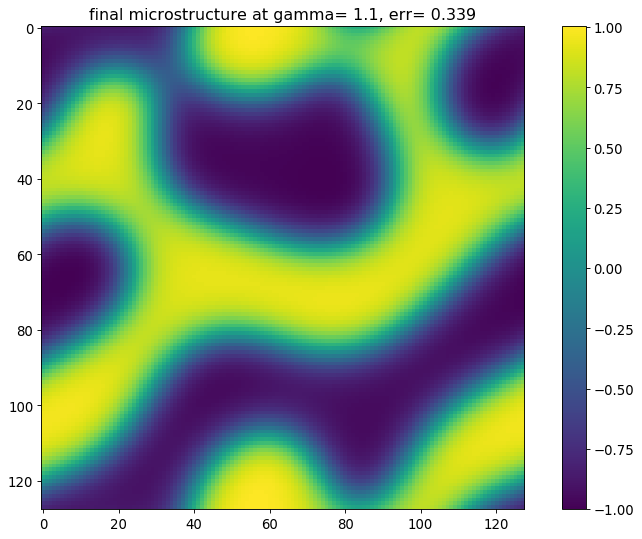

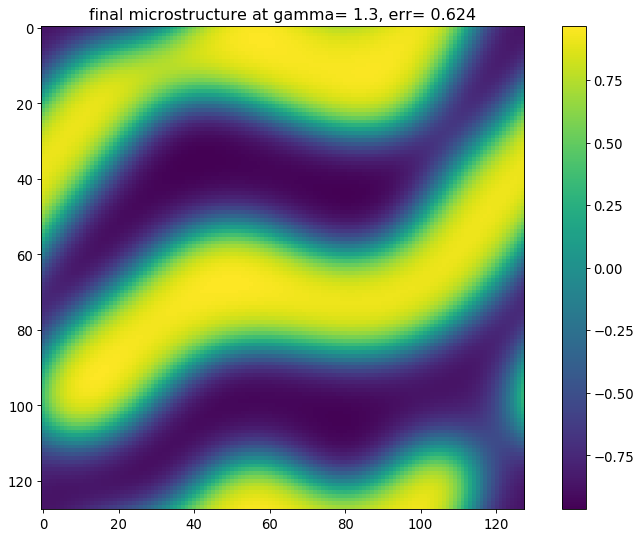

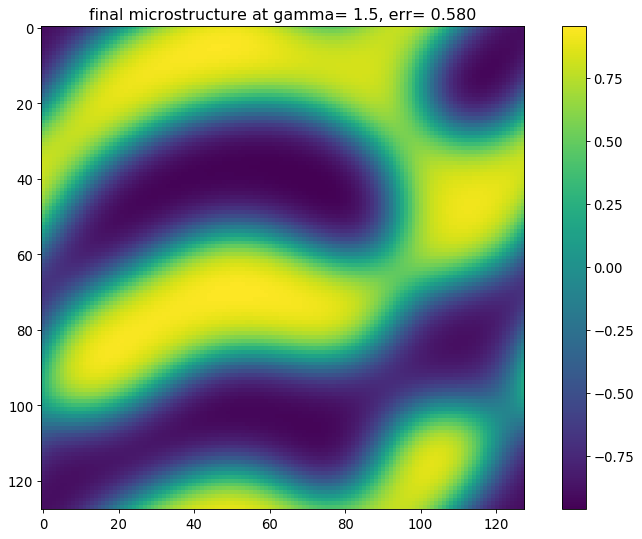

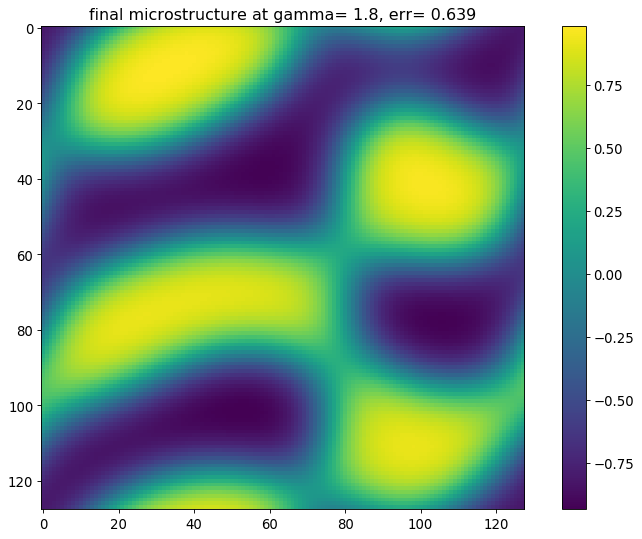

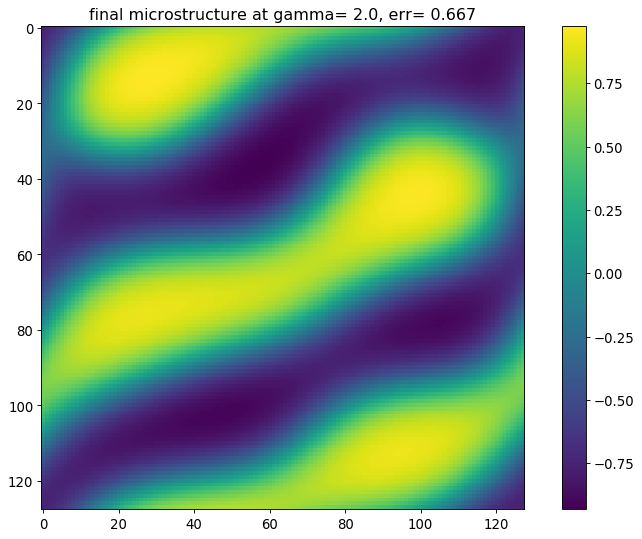

CPU times: user 29.7 s, sys: 421 ms, total: 30.1 s
Wall time: 17.8 s


In [25]:
%%time
center = 0.0
scale = 1.0
x_init = x_copy.copy()[:2]*scale + center
x_base = ch.ch_run_torch(x_init, dt=dt, gamma=gamma*1, dx=dx, sim_step=sim_steps*save_steps, device=device)
draw_im(x_init[0], "initial microstructure at scale :{} and mean conc. {}".format(0.01, center))
draw_im(x_base[0], "final microstructure at scale :{} and mean conc. {}".format(scale, center))



# for scale in [1, 2.5, 5, 7.5, 10]:
#     center = 0.0
#     x_data = x_copy.copy()[:2]*scale + center
#     print("diff in init microstructure: {:1.3f}".format(rmserror(x_init, x_data)))
#     x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma*1, dx=dx, sim_step=sim_steps*save_steps, device=device)
#     draw_im(x_data[0], "final microstructure at scale :{}, err: {:1.3f}".format(scale, rmserror(x_data, x_base)))
    
# for center in [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]:
#     scale = 1
#     x_data = x_copy.copy()[:2]*scale + center
#     x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma*1, dx=dx, sim_step=sim_steps*save_steps, device=device)
#     draw_im(x_data[0], "final microstructure at mean conc. :{}, err: {:1.3f}".format(center, rmserror(x_data, x_base)))

    
for g_factor in [0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.3, 1.5, 1.8, 2.0]:
    scale = 1
    center = 0
    x_data = x_copy.copy()[:2]*scale + center
    x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma*g_factor, dx=dx, sim_step=sim_steps*save_steps, device=device)
    draw_im(x_data[0], "final microstructure at gamma= {:1.1f}, err= {:1.3f}".format(g_factor, rmserror(x_data, x_base)))



# Microstructure Evolution in PC space

In [9]:
import pymks
from pymks import LegendreBasis
from sklearn.decomposition import PCA

In [117]:
%%time
nsamples = 20 # no. of samples
dim_x = 96
dim_y = dim_x
dx = 0.25 # delta space_dim
dt = 0.01 # delta time
gamma = 1.0 # interface energy
means = np.arange(-0.2,0.2, 0.01)


domain = [-1.1, 1.1]
n_states = 5
basis = LegendreBasis(n_states, domain)

correlations=[(1,1), (1,2), (1,3), (1,4), 
              (2,2), (2,3), (2,4),
              (3,3), (3,4), 
              (4,4)]


sim_steps = 1000 # simulation steps
save_steps = 10 # time step for which data is saved
stat_shape = (nsamples*len(means), (dim_x * dim_y * len(correlations)))

CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 38.9 µs


In [155]:
def magic1(n):
    # https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    sieve[0] = False
    for i in range(int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[      ((k*k)//3)      ::2*k] = False
            sieve[(k*k+4*k-2*k*(i&1))//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0]+1)|1)]

In [159]:
primes = magic1(1000)

In [160]:
%%time
x_data = []

for i1, mean in enumerate(means):
    x_data.append(init_norm(nsamples, dim_x, dim_y, mean=mean, std=0.01, seed=87345*primes[i]))
x_data = np.concatenate(x_data, axis=0)

CPU times: user 303 ms, sys: 11.3 ms, total: 315 ms
Wall time: 315 ms


In [162]:
y_data = x_data.copy()
f_data = []

for i in tqdm.tqdm_notebook(range(save_steps)):
    
    y_data = ch.ch_run_torch(y_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    y_corr = pymks.stats.correlate(y_data, basis, periodic_axes=[0,1], correlations=correlations)
    
    f_data.append(np.reshape(y_corr, stat_shape))

f_data = np.concatenate(f_data, axis=0)

/storage/home/hhive1/ashanker9/data/anaconda3/envs/chnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [35]:
# y_corr = pymks.stats.correlate(y_data, basis, periodic_axes=[0,1], correlations=correlations)
# s_data = np.reshape(y_corr, (y_data.shape[0], 96*96*10))
# pca = PCA(n_components=50)
# scores = pca.fit_transform(f_data)

In [163]:
%%time
pca = PCA(n_components=50)
scores = pca.fit_transform(f_data)

CPU times: user 47.5 s, sys: 2.47 s, total: 50 s
Wall time: 13.9 s


In [164]:
nstep = (nsamples*len(means))
sc = 8

c = np.ravel([[m]*nsamples for  m in means])
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# bounds = np.unique(c)
bounds = means.copy()
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# ticks = means.copy()
xlims = [np.floor(scores[:,0].min())-10, np.ceil(scores[:,0].max())+10]
ylims = [np.floor(scores[:,1].min())-10, np.ceil(scores[:,1].max())+10]

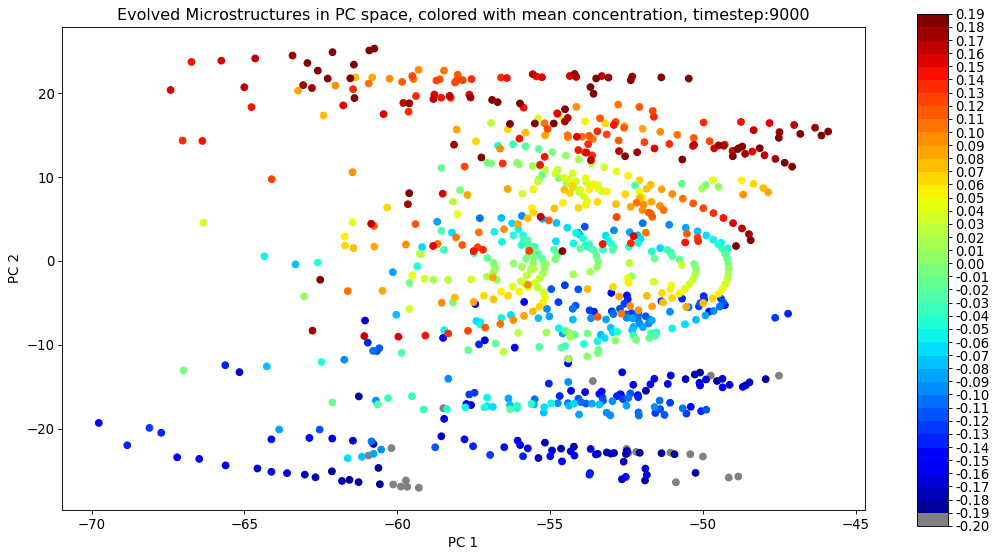

In [165]:
ix = 9
fig = plt.figure(figsize=(sc*1.61803398, sc))
x = scores[ix*nstep:(ix+1)*nstep,0]
y = scores[ix*nstep:(ix+1)*nstep,1]

plt.scatter(x, y, c=c, cmap=cmap, norm=norm)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Evolved Microstructures in PC space, colored with mean concentration, timestep:{}".format(ix*sim_steps))
# plt.xlim(xlims)
# plt.ylim(ylims)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1.2f')
plt.show()

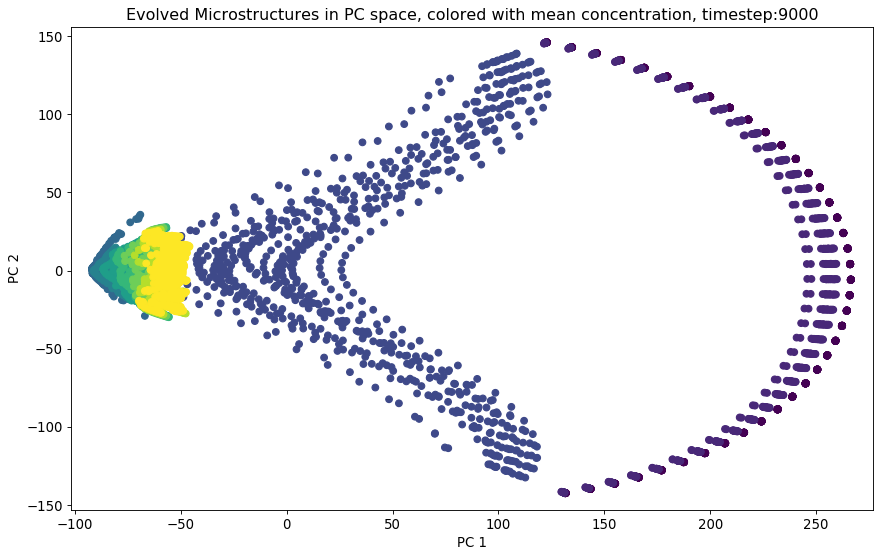

In [170]:
fig = plt.figure(figsize=(sc*1.61803398, sc))
x = scores[:,0]
y = scores[:,1]

plt.scatter(x, y, c=np.ravel([[i]*800 for i in range(10)]))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Evolved Microstructures in PC space, colored with mean concentration, timestep:{}".format(ix*sim_steps))
# plt.xlim(xlims)
# plt.ylim(ylims)
# ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
# cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
#     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1.2f')
plt.show()

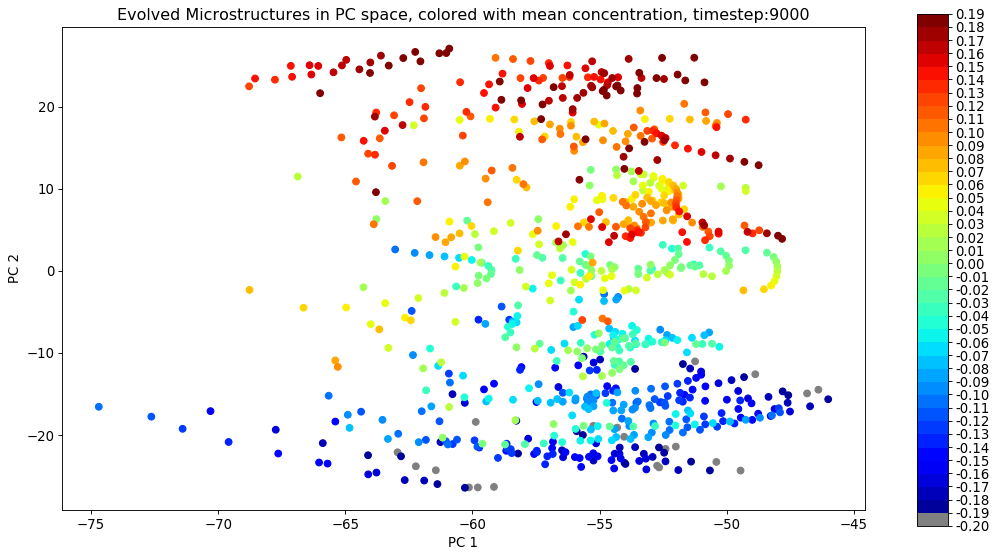

In [136]:
ix = 9
fig = plt.figure(figsize=(sc*1.61803398, sc))
x = scores[ix*nstep:(ix+1)*nstep,0]
y = scores[ix*nstep:(ix+1)*nstep,1]

plt.scatter(x, y, c=c, cmap=cmap, norm=norm)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Evolved Microstructures in PC space, colored with mean concentration, timestep:{}".format(ix*sim_steps))
# plt.xlim(xlims)
# plt.ylim(ylims)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1.2f')
plt.show()

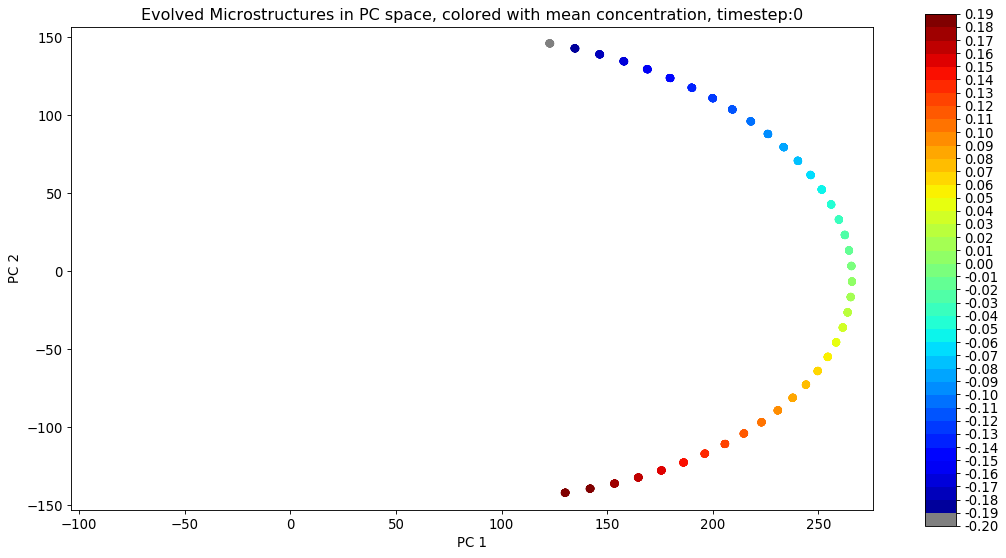

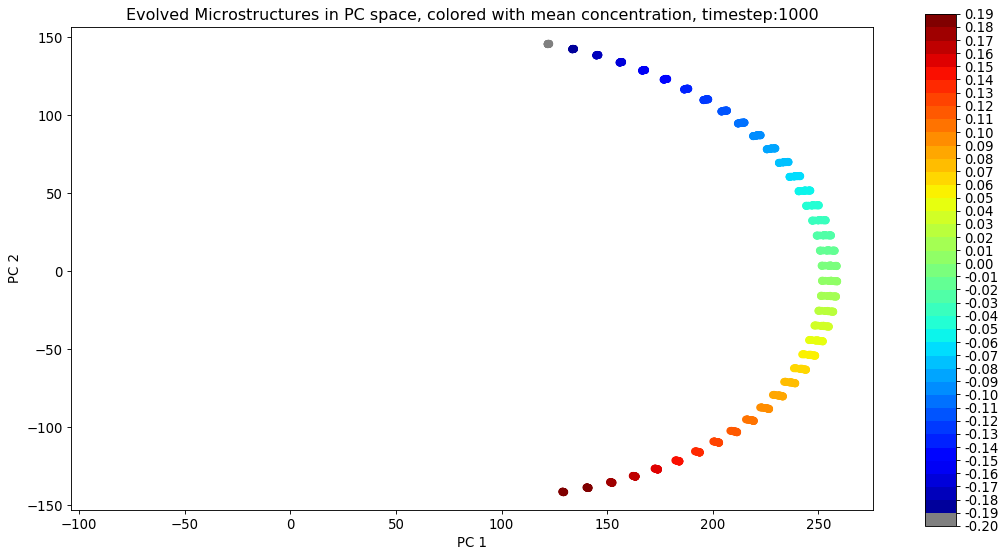

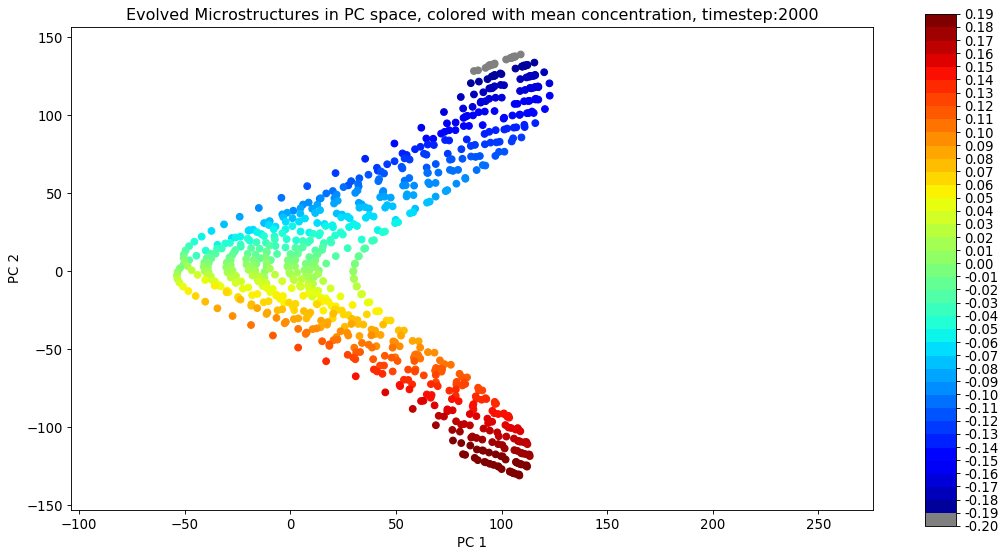

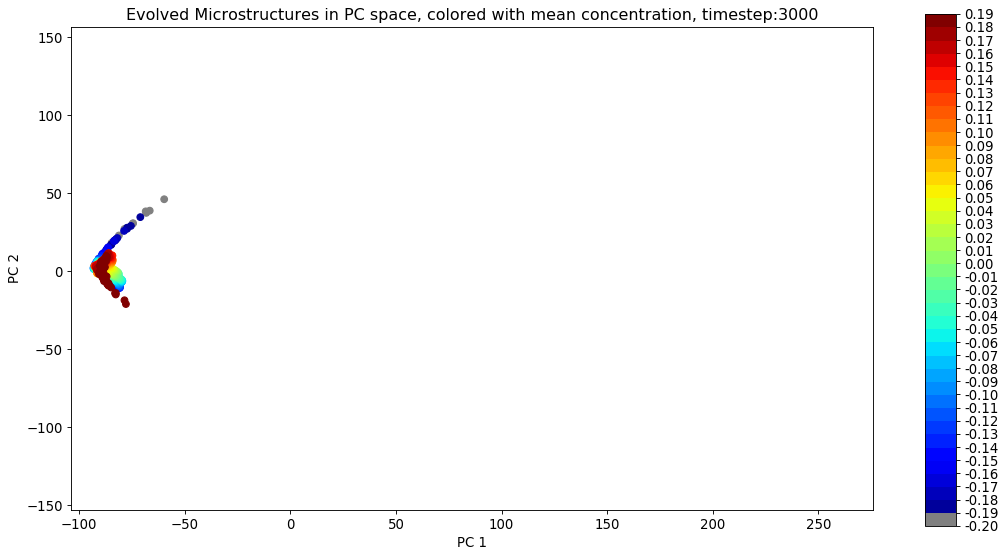

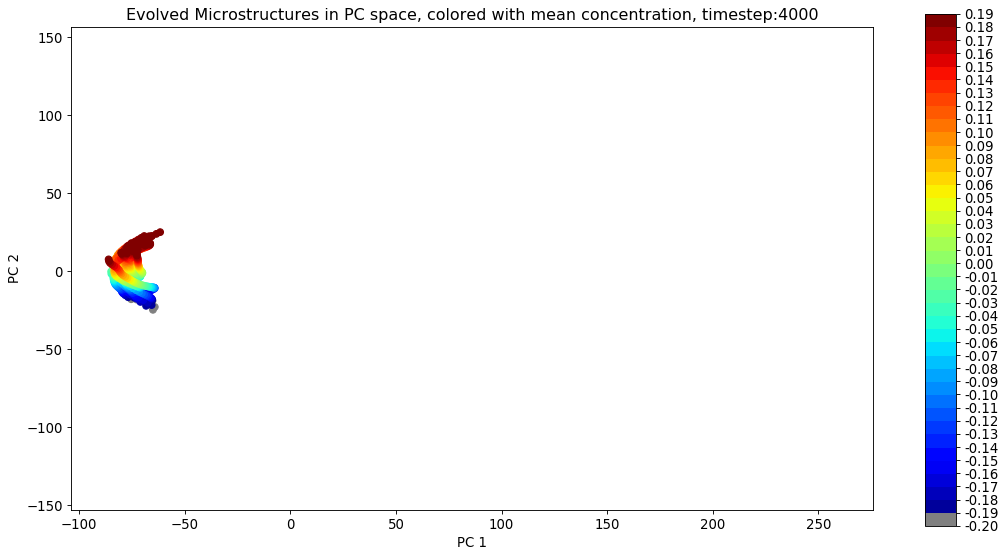

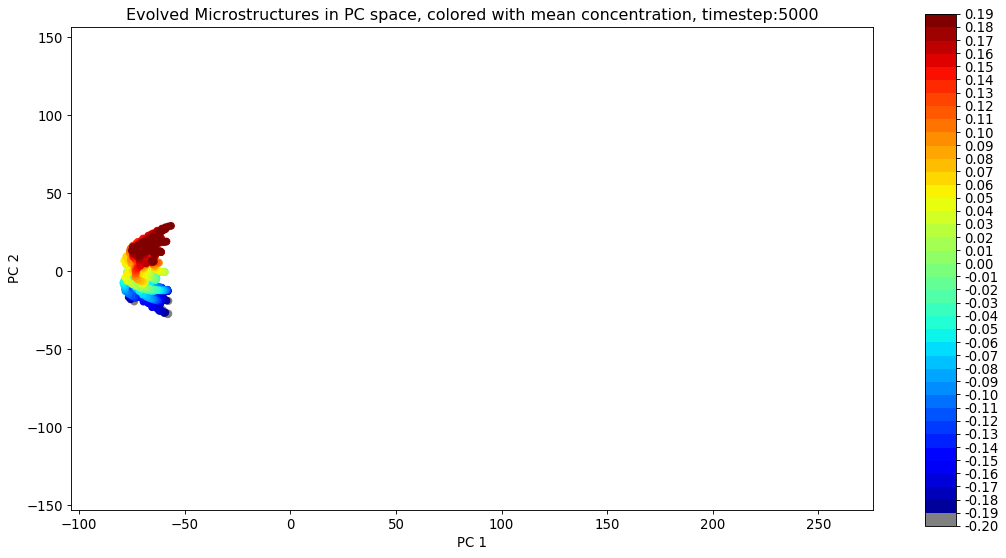

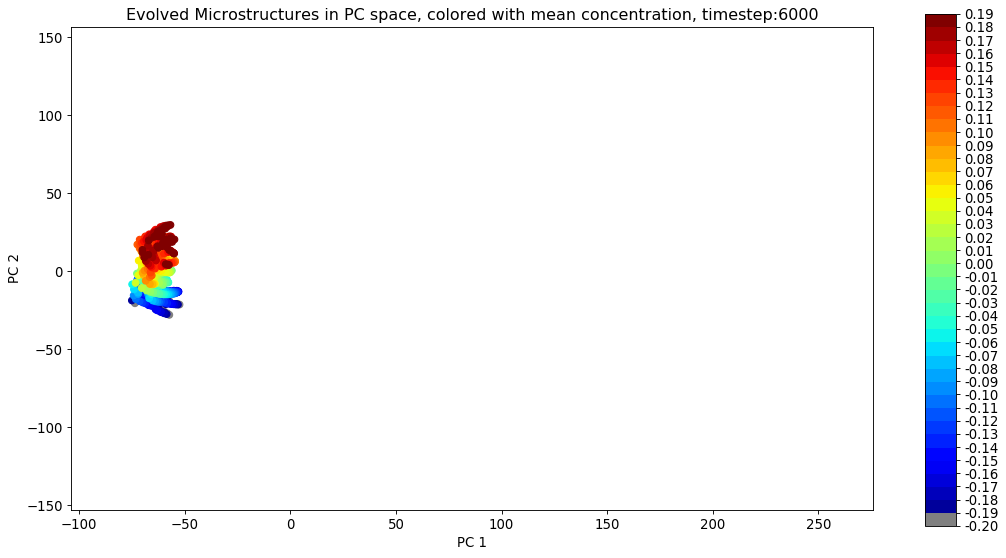

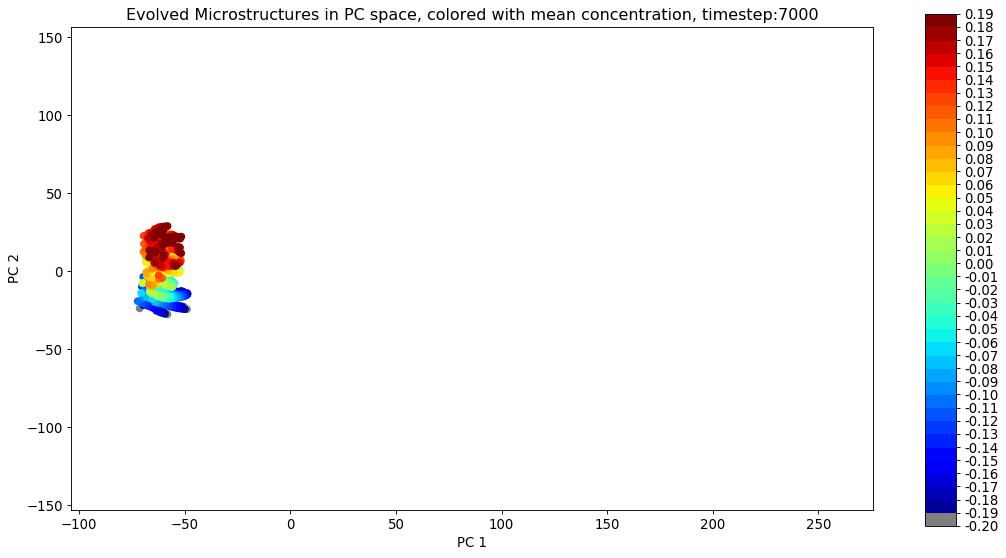

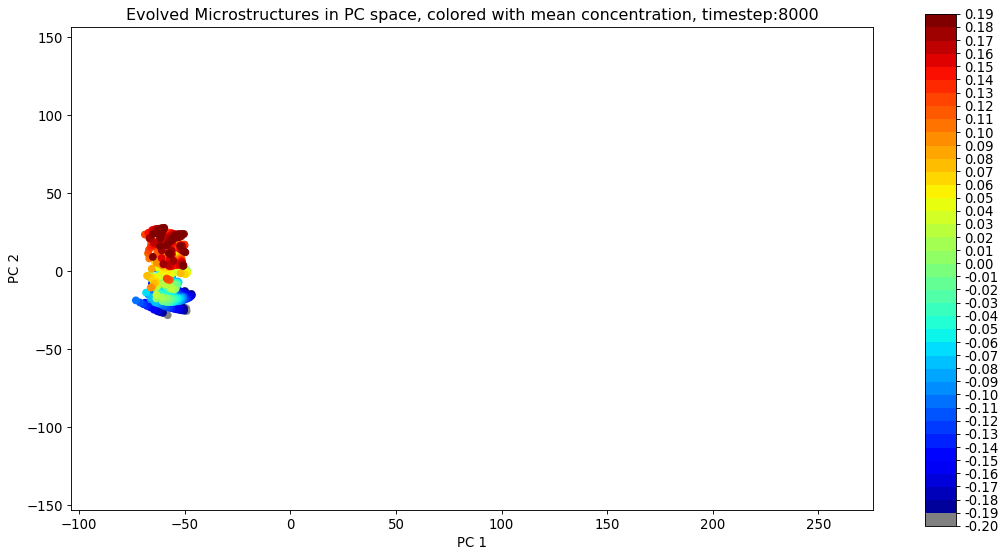

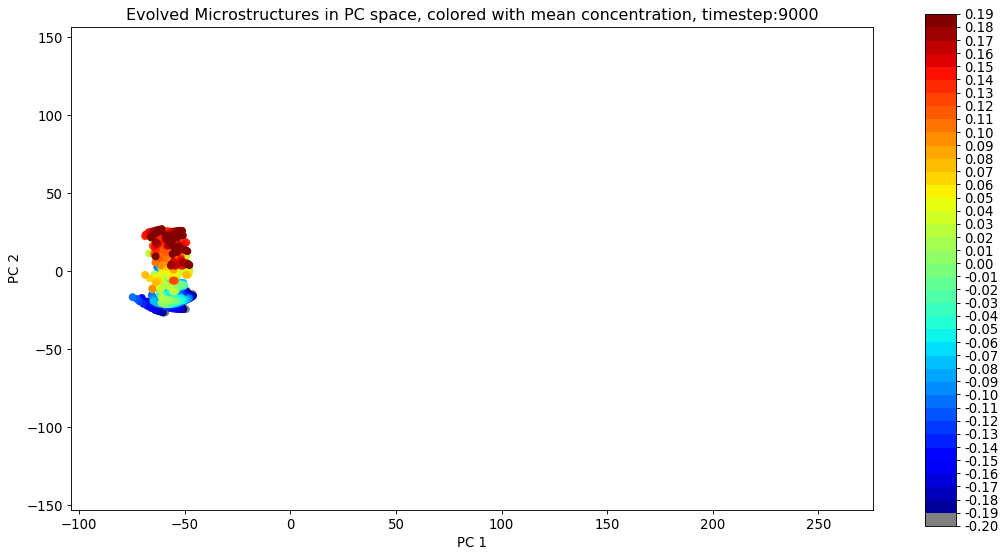

In [122]:
for ix in range(10):
    fig = plt.figure(figsize=(sc*1.61803398, sc))
    x = scores[ix*nstep:(ix+1)*nstep,0]
    y = scores[ix*nstep:(ix+1)*nstep,1]
        
    plt.scatter(x, y, c=c, cmap=cmap, norm=norm)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Evolved Microstructures in PC space, colored with mean concentration, timestep:{}".format(ix*sim_steps))
    plt.xlim(xlims)
    plt.ylim(ylims)
    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1.2f')
    plt.show()

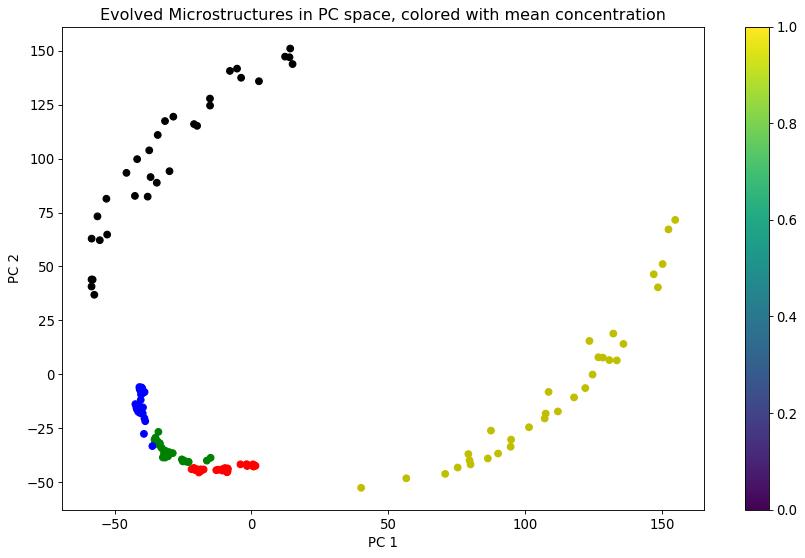

In [40]:
n_step = (nsamples*5)

sc = 8
c = np.ravel([["y"]*nsamples + ["r"]*nsamples + ["g"]*nsamples + ["b"]*nsamples + ["k"]*nsamples])

fig = plt.figure(figsize=(sc*1.61803398, sc))


plt.scatter(scores[-n_step:,0], scores[-n_step:,1], c=c)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Evolved Microstructures in PC space, colored with mean concentration")
# plt.legend(["mean:-0.2", "mean:0.0", "mean:0.2"])
plt.colorbar(c1)
plt.show()

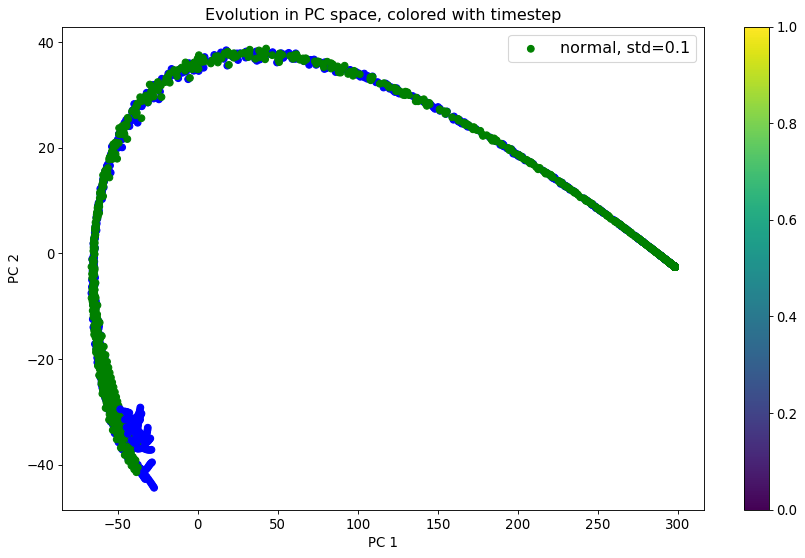

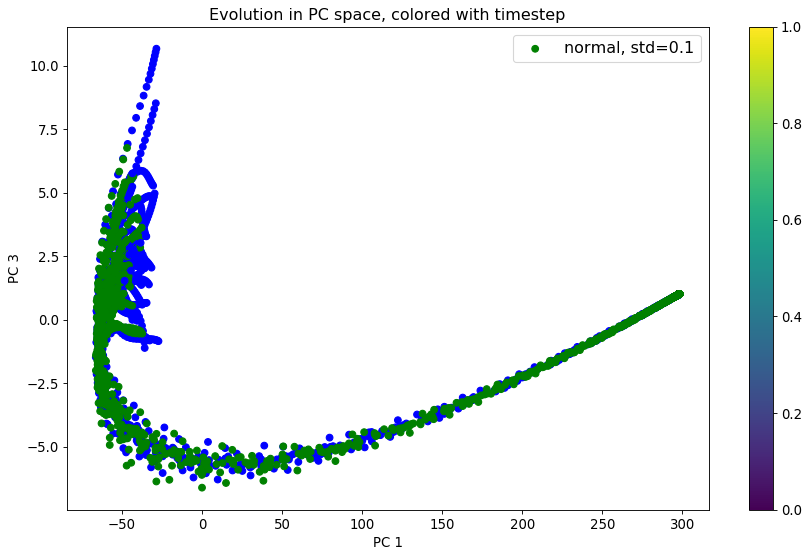

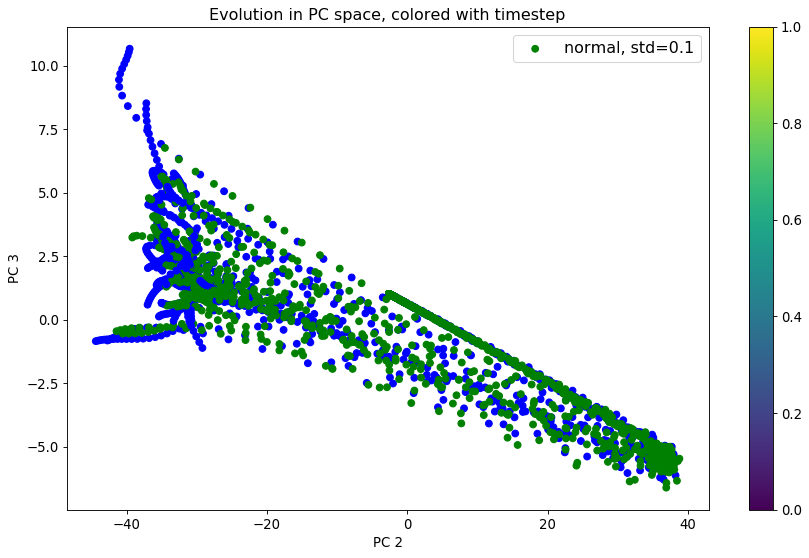

In [127]:
n_step = (nsamples*3) * 50

sc = 8
c = np.ravel([["r"]*(nsamples) + ["g"]*(nsamples) + ["b"]*(nsamples)]*save_steps)[:n_step]

fig = plt.figure(figsize=(sc*1.61803398, sc))
ax = fig.add_subplot(111)
c1 = ax.scatter(scores[:n_step,0], scores[:n_step,1], c=c)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Evolution in PC space, colored with timestep")
plt.legend(["normal, std=0.1", "normal, std={:1.1f}".format(0.1*scale)])
plt.colorbar(c1)

plt.show()

fig = plt.figure(figsize=(sc*1.61803398, sc))
ax = fig.add_subplot(111)
c1 = ax.scatter(scores[:n_step,0], scores[:n_step,2], c=c)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 3")
ax.set_title("Evolution in PC space, colored with timestep")
plt.colorbar(c1)
plt.legend(["normal, std=0.1", "normal, std={:1.1f}".format(0.1*scale)])
plt.show()

fig = plt.figure(figsize=(sc*1.61803398, sc))
ax = fig.add_subplot(111)
c1 = ax.scatter(scores[:n_step,1], scores[:n_step,2], c=c)
ax.set_xlabel("PC 2")
ax.set_ylabel("PC 3")
ax.set_title("Evolution in PC space, colored with timestep")
plt.colorbar(c1)
plt.legend(["normal, std=0.1", "normal, std={:1.1f}".format(0.1*scale)])
plt.show()

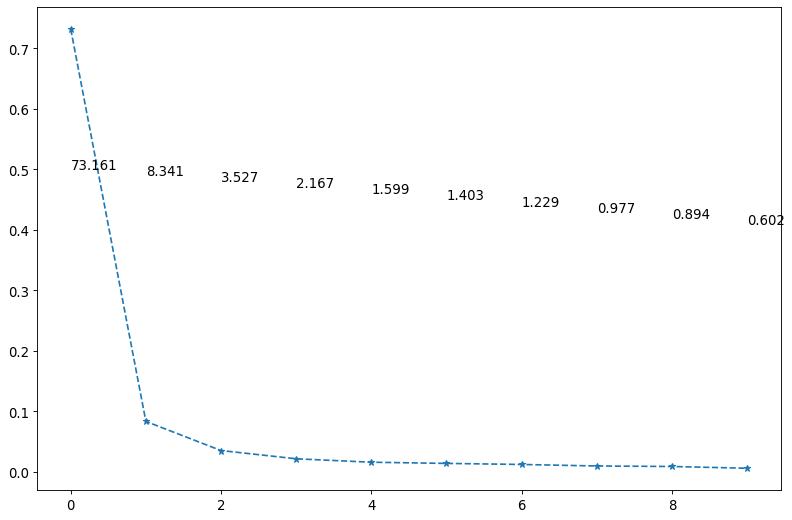

In [128]:
plt.plot(pca.explained_variance_ratio_[:10], "--*")

for i, r in enumerate(pca.explained_variance_ratio_[:10]):
    plt.text(i, 0.5-0.01*i, "{:1.3f}".format(r*100))
plt.show()

In [142]:
tstep = 0
d_list = {}
for tstep in range(0, save_steps, 5):
    d = np.sqrt(np.sum((scores[tstep*(nsamples*2):(tstep+1)*(nsamples*2)] - np.mean(scores[tstep*(nsamples*2):(tstep+1)*(nsamples*2)], axis=0))**2, axis=1))
    d_list[tstep] = d
    print(tstep, np.mean(d), np.std(d))

0 0.2174934790093459 0.0452651864195633
5 1.2101123355157053 0.3556457782880998
10 9.829157027887874 3.120256834714335
15 64.52696460576821 16.76899587364226
20 156.1579007771358 13.606918063891564
25 124.47319120244856 17.843622119349337
30 49.23498868625589 10.22212707733095
35 33.215266471370136 10.429848118320852
40 28.860116511426135 11.224831712561206
45 28.335711401977612 11.808928335396471
50 29.409414201837258 12.735303451619739
55 30.94590075798522 13.912840440350744
60 32.570547109650235 15.010495052302403
65 34.06333174798158 15.866442545472403
70 35.35166939541867 16.48570602021415
75 36.44079858275486 16.922658037950367
80 37.36002693495624 17.243339589711937
85 38.1664999294411 17.50501484931166
90 38.92760601471721 17.748679437239645
95 39.70913014783678 18.01476042851122
100 40.60641563155046 18.32303483798114
105 41.74398098479371 18.662015872785467
110 42.997917219228285 19.170316760815034
115 44.72102490333374 19.674885150182302
120 46.816503910830335 20.34651520404

In [139]:
tstep = 0
d_list = {}
for tstep in range(0, save_steps, 5):
    d = np.sqrt(np.sum((scores[tstep*(nsamples*2)+nsamples:(tstep+1)*(nsamples*2)] - np.mean(scores[tstep*(nsamples*2)+nsamples:(tstep+1)*(nsamples*2)], axis=0))**2, axis=1))
    d_list[tstep] = d

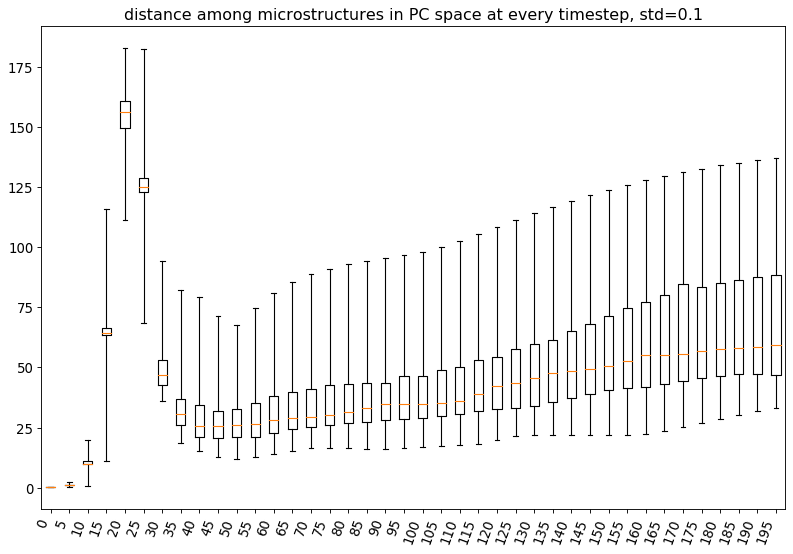

In [143]:
# or backwards compatable    
labels, data = d_list.keys(), d_list.values()

plt.boxplot(data, whis="range")
plt.xticks(range(1, len(labels) + 1), labels)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right',)
plt.title("distance among microstructures in PC space at every timestep, std=0.1")
plt.show()

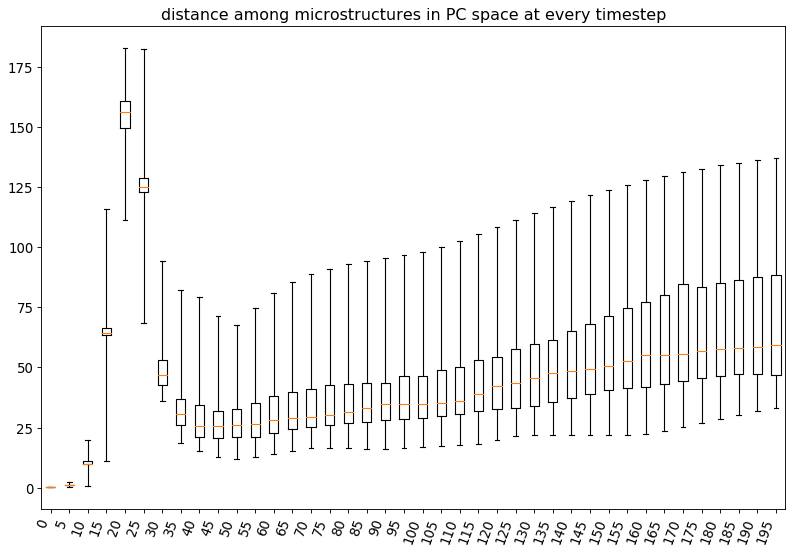

In [133]:
# or backwards compatable    
labels, data = d_list.keys(), d_list.values()

plt.boxplot(data, whis="range")
plt.xticks(range(1, len(labels) + 1), labels)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right',)
plt.title("distance among microstructures in PC space at every timestep")
plt.show()